In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow
%matplotlib inline

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array

In [3]:
plt.rcParams['figure.figsize'] = (10, 8) # set default figure size, 10in by 8in

# Chapter 9: Advanced Deep Learning for Computer Visison

Supporting materials for:

Chollet (2021). *Deep Learning with Python*. v2 Manning Publications Co. 

Chapter 9 *Advanced Deep Learning for Computer Visison*

# 9.1 Three essential computer vision tasks

In the previous lectures/chapters we had an example of an image classification task.  The dogs vs. cats task is a binary image classification task,
where we are determining a binary label (dog or cat) for the whole image as an input to be labeled.

But image classification is only one of several possible applications of deep learning in computer vision.   There are three basic and most commonly
used computer vision tasks:

1. **Image classification** - Where the goal is to assign one or more labels to an image.  It may be either single-label classification or multi-label
   classification.  The labels could be a binary label (dog vs. cat), or a multi-class (e.g. ImageNet where images are classified into 1 of 1000 classes in
   the most typical restricted version of the classification task).
2. **Image segmentation** - Where the goal is to "segment" or "partition" an image into different areas.  Each area usuall represents a category.
   Segmentation is a pixel-level operation, where we want to identify a set of pixels that are likely some class of interest.
3. **Object detection** - I similar to segmentation, but the goal is to draw rectangles (called **bounding boxes**) around objects
   of interest in an image.  We usually also want to associate each bounding box with a class.  For example in a self-driving car
   application, we could use object-detection to identify and bound other cars, pedestians, and traffic signs.
   
There are many other computer vision tasks, such as image similarity, pose estimation, 3D mesh estimation and so on.  But these 3 basic tasks are
a foundation for many of these other types of computer vision tasks.

We have seen an example of image classification in previous lectures/chapters, so in this chapter we look at segmentation.

This chapter doesn't have an example of object detection, but recommends looking at RetinaNet example on keras.io for a complete
example of object detection [RetinaNet on keras.io Example](https://keras.io/examples/vision/retianet/)
   

# 9.2 An image segmentation example

Image segmentation is about using a model to assign a class to each pixel in an image, thus *segmenting* the image into different zones.

There are often some default zones, like "background" and "foreground" to segment areas not recognized and/or probably not of interest to the application.

But other examples of zones like "people", "road", "car" can then also be defined.

There are two different approaches to image segmentation that have traditionally been applied:

1. **Semantic segmentation**: where each pixel is independently classified into a semantic category, like "cat".  If there are two cats in the image, all pixels are mapped to the
   same generic cat. This method implies we need one output label for every input pixel in the original image.
2. **Instance segmentation**: which seeks to parse out individual objects, so it is a bit in between segmentation and object detection.  In an image with two cats in it,
   instance segmentation would (hopefully when working) identify "cat 1" and "cat 2" as two separate classes of pixel (but of the category cat).
   
Semantic segmentation is simpler, and we look at semantic segmentation in the following example.

This example uses the [Oxford-IIIT Pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which contains 7,390 pictures of various breeds of cats and dogs,
together with foreground-background segmentation masks for each picture. A **segmentation mask** is the image-segmentation equivalent of a label:
it's an image the same size as the input image, with a single color channel where each integer value corresponds to the class of the corresponding pixel in the
input image.

In this segmentation task, the pixels of the segmentation task have one of three integer values:

- 1 (foreground)
- 2 (background)
- 3 (contour)

## Data acquisition

We need to download and extract the dataset by hand.  The following assumes a linux/unix environment with wget/tar utilities, you may need to download and extract by hand if you
don't have these utilities

In [4]:
# uncomment these to perform the commands, these download and extraction into our project ../data
# directory.  If you don't have the appropriate tools, need to download and extract by hand

# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -O ../data/images.tar.gz

In [5]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -O ../data/annotations.tar.gz

In [6]:
# !tar -xf ../data/images.tar.gz --directory ../data

In [7]:
# !tar -xf ../data/annotations.tar.gz --directory ../data

Input pictures in the images folder are JPG files, and segmentation mask is stored as a PNG file (for some reason).
The corresponding mask has the same name put in the annotations/trimaps folder.

The following creates a simple list of input file names and target (annotation mask) file names for use
in training the segmentation model.

In [8]:
input_dir = "../data/images/"
target_dir = "../data/annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")]
)

target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")]
)


In [9]:
print( len(input_img_paths) )
print( len(target_paths) )
print( input_img_paths[0] )
print( target_paths[0] )

7390
7390
../data/images/Abyssinian_1.jpg
../data/annotations/trimaps/Abyssinian_1.png


To get a feel for things, here is a quick look at a sample image and its corresponding target annotation mask.

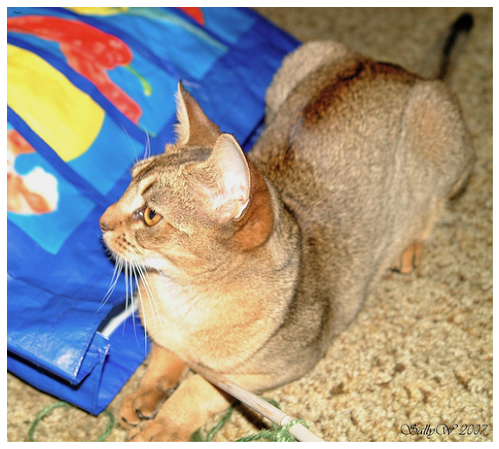

In [10]:
# show one of the images
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]));

In [11]:
# show the corresponding segmentation target

def display_target(target_array):
    """Need to do a bit of work to interpret segmentation target array.  This function takes the
    png image file loaded as grayscale so that the image is treated as having a single color channel.
    The original labels are 1, 2, 3 so we subtract 1 and multiply by 127 so lables become 
    0 (black), 127 (gray) and 254 (near-white).
    """
    # convert labels 1, 2, 3 to new target pixel values 0, 127, 254
    normalized_array = (target_array.astype("uint8") - 1) * 127
    
    # then plot it, notice we extract only color channle 0 for plot
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])


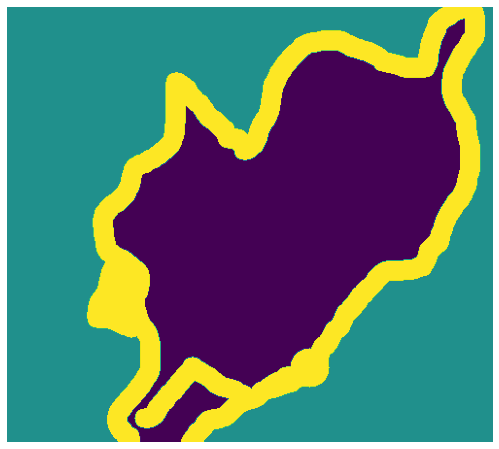

In [12]:
    
# display the same image segmentation map
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

## Data preparation

Next we load inputs and targets into NumPy arrays, and split into training and validation sets.  We don't use any
fancy image streaming here since the dataset is small and should all fit comfortable into memory this time.

In [13]:
# we resize/normalize everything to be 200x200 in shape
img_size = (200, 200)

# total number of samples in the data
num_imgs = len(input_img_paths)
# seem to be blowing my 4GB GPU memory, reduce number of images used to get it to work
#num_imgs = 2000 

# Shuffle the file paths (they were originally sorted by breed).  Need to do this
# so when we tran/validate split we don't end up with all of 1 breed in training,
# and none in validation for example.
# A bit of a trick but using the same seed in both suffles ensures the input
# paths and target paths stay in same order.
seed = 1337
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_paths)

In [14]:
# some small function to help data preparation

def path_to_input_image(path):
    """Given filename/filepath, load and return the image array.  Notice by
    default we normalize all images to the target_size
    """
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    """Given a target filename/filepath, load and return the image array.
    Here we normalize all image sizes, and we also perform the conversion as before, though
    here we leave the labels as 0, 1 or 2 for the segmentation masks.
    """
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    
    # subtract 1 so labels are now 0, 1 or 2
    img = img.astype("uint8") - 1
    
    return img

In [15]:
# Initialize emtpy input and target numpy arrays.  Notice resulting shapes
# of input and target arrays, first dimension is the sample number, next two dimensions
# are the pixel location, then there are 3 or 1 color dimenstions.
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

print(input_imgs.shape)
print(targets.shape)

(7390, 200, 200, 3)
(7390, 200, 200, 1)


In [16]:
# Now load all of the images.  input_imgs is a float32 array and the
# target masks are uint8 arrays.  The inputs have 3 channels (RBG values)
# and the target have a single channel (which contains the integer label).
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [17]:
# split data into training set and validation set.  We use last 1000
# of the shuffled images for validation, and the first 6390 are for training
num_val_samples = 1000
#num_val_samples = 300

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

## Model definition

Now its time to define the model we will use to solve this image segmentation task.  The main portions of this model use layers of
`Conv2D` convolutional layers with simple `relu` activation.  Notice the output layer has a per-pixel 3-way softmax to classifiy
each output pixel into one of our three categories.

In [18]:
def get_model(img_size, num_classes):
    """Helper method to create and return a fresh model, so we can perform training multiple times.
    The inputs defined the input img_size which is also the output size plus number of segmentation classes
    we need to identify for each pixel.
    """
    inputs = keras.Input(shape=img_size + (3,))
    # don't forget to rescale input images to the [0-1] range.
    x = layers.Rescaling(1./255)(inputs)   
    
    # note how we use padding="same" everywhere to avoid the influence of border padding
    # on feature map size.
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(
        64, 3, activation="relu", padding="same", strides=2)(x)
    
    # we end the model with a per-pixel three-way softmax to classify each output pixel into one of our 
    # three categories
    outputs = layers.Conv2D(num_classes, 3, activation="softmax",
        padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model   

In [19]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

2022-03-02 10:13:34.276463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 10:13:34.281839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 10:13:34.282141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 10:13:34.282836: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

The first half of model resembles kind of convnet you'd use for image classification, a stack of `Conv2D` layers with gradually increasing
filster sizes. The purpose of first half is to encode the images into smaller feature maps.

One difference in first half is the way downsampling is accomplished.  Instead of max pools, strides are added to every other convolution layer.
For image segmentation we care a lot about the *spatial location* of information in the image.  Pooling destroys location information.  So max
pooling performs well for classification tasks, but hurt segmentation tasks.  Meanwhile strides do a better job of downsampling the
feature maps while retaining location information.

The second half of the model uses `Conv2DTranspose` layers.  The final output needs to be the same shape as the original input, but from first half
of the network so far we have reduced shape down feature mas of shape (25, 25, 256).  Therefore we desire to apply a kind of *inverse* of the transformations
done so far.  We will think of this as **upsampling** the feature maps instead of the downsampling we have looked at so far.

## Train the Model

We can now try to compile and fit the model and see how it performs on training and validation data.

In [20]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
    save_best_only=True)
]


In [23]:
with tensorflow.device('/CPU:0'):
    history = model.fit(train_input_imgs, train_targets,
                        epochs=50,
                        callbacks=callbacks,
                        batch_size=64,
                        validation_data=(val_input_imgs, val_targets))

Epoch 1/50
  6/100 [>.............................] - ETA: 18:38 - loss: 1.8100

KeyboardInterrupt: 